# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    preprocess = transforms.Compose([transforms.Resize(image_size),transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir,transform=preprocess)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [21]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

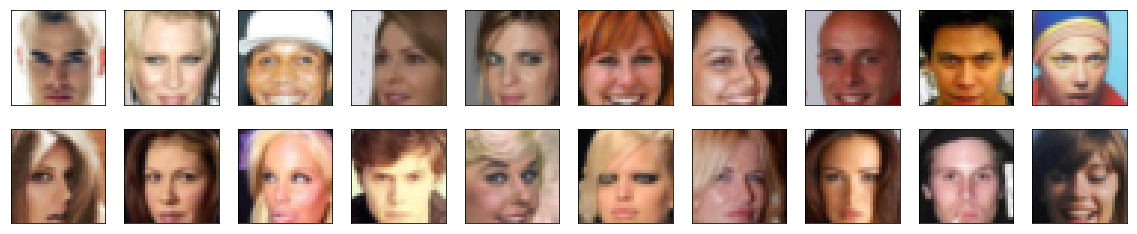

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    max_ = feature_range[1]
    min_ = feature_range[0]
    x = x*(max_-min_)+min_
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.8431)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding = 1, batch_norm= True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                       kernel_size = kernel_size, stride = stride, padding = padding, bias = False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [10]:
###
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # (16, 16, conv_dim)
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (8, 8, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (4, 4, conv_dim*4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (2, 2, conv_dim*8)
        
        self.classifier = nn.Linear(conv_dim*8*2*2, 1)

        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # Leaky ReLU can have an advantage over ReLU 
        # https://www.reddit.com/r/MachineLearning/comments/4znzvo/what_are_the_advantages_of_relu_over_the/
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = F.leaky_relu(self.conv4(out), 0.2)
        
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.classifier(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 4, 4)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        
        # last layer: tanh activation instead of relu
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [21]:
###
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model: convolutional and linear
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    isConvolution = classname.find('Conv') != -1
    isLinear = classname.find('Linear') != -1
    if (hasattr(m, 'weight') and isConvolution or isLinear):
        init.normal_(m.weight.data, 0.0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [15]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [17]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) #* 0.9
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    #loss = torch.mean((D_out-1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    #loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [18]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), 0.0002, [0.5, 0.999])
g_optimizer = optim.Adam(G.parameters(), 0.0002, [0.5, 0.999])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [19]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            if train_on_gpu:
                real_images = real_images.cuda()
            d_optimizer.zero_grad()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            fake_images = G(fixed_z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            fake_images = G(fixed_z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
                

        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
    ###
        fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
        for ax, img in zip(axes.flatten(), samples_z):
            img = img.detach().cpu().numpy()
            img = np.transpose(img, (1, 2, 0))
            img = ((img + 1)*255 / (2)).astype(np.uint8)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            im = ax.imshow(img.reshape((32,32,3)))
        plt.show()
    ###
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

Epoch [    1/   20] | d_loss: 1.7018 | g_loss: 2.8149
Epoch [    1/   20] | d_loss: 1.4196 | g_loss: 3.6699
Epoch [    1/   20] | d_loss: 1.3134 | g_loss: 2.6853
Epoch [    1/   20] | d_loss: 1.4203 | g_loss: 2.4122
Epoch [    1/   20] | d_loss: 0.9897 | g_loss: 1.8553
Epoch [    1/   20] | d_loss: 0.8676 | g_loss: 2.0301
Epoch [    1/   20] | d_loss: 1.0863 | g_loss: 1.5206
Epoch [    1/   20] | d_loss: 1.0474 | g_loss: 1.3536
Epoch [    1/   20] | d_loss: 1.0394 | g_loss: 2.9685
Epoch [    1/   20] | d_loss: 1.8627 | g_loss: 2.6098
Epoch [    1/   20] | d_loss: 0.6839 | g_loss: 3.0356
Epoch [    1/   20] | d_loss: 0.8400 | g_loss: 1.6746
Epoch [    1/   20] | d_loss: 0.6916 | g_loss: 2.0657
Epoch [    1/   20] | d_loss: 1.2253 | g_loss: 1.7825
Epoch [    1/   20] | d_loss: 0.8318 | g_loss: 1.7783
Epoch [    1/   20] | d_loss: 0.6793 | g_loss: 2.6535
Epoch [    1/   20] | d_loss: 1.1351 | g_loss: 2.2976
Epoch [    1/   20] | d_loss: 0.6625 | g_loss: 2.0356
Epoch [    1/   20] | d_loss

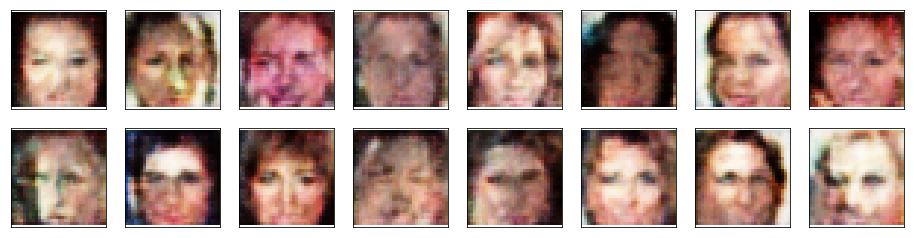

Epoch [    2/   20] | d_loss: 0.7247 | g_loss: 2.2098
Epoch [    2/   20] | d_loss: 0.5101 | g_loss: 2.6849
Epoch [    2/   20] | d_loss: 0.7788 | g_loss: 2.3340
Epoch [    2/   20] | d_loss: 1.0023 | g_loss: 2.3893
Epoch [    2/   20] | d_loss: 0.5879 | g_loss: 2.4075
Epoch [    2/   20] | d_loss: 1.0151 | g_loss: 3.2189
Epoch [    2/   20] | d_loss: 1.4653 | g_loss: 2.9119
Epoch [    2/   20] | d_loss: 1.0720 | g_loss: 3.9424
Epoch [    2/   20] | d_loss: 2.2112 | g_loss: 1.1196
Epoch [    2/   20] | d_loss: 0.8176 | g_loss: 2.0148
Epoch [    2/   20] | d_loss: 0.5961 | g_loss: 2.4209
Epoch [    2/   20] | d_loss: 0.5322 | g_loss: 3.4948
Epoch [    2/   20] | d_loss: 0.7928 | g_loss: 3.7623
Epoch [    2/   20] | d_loss: 0.7234 | g_loss: 2.3563
Epoch [    2/   20] | d_loss: 0.9558 | g_loss: 2.3180
Epoch [    2/   20] | d_loss: 0.6001 | g_loss: 3.2474
Epoch [    2/   20] | d_loss: 0.6848 | g_loss: 2.7370
Epoch [    2/   20] | d_loss: 0.8100 | g_loss: 2.1761
Epoch [    2/   20] | d_loss

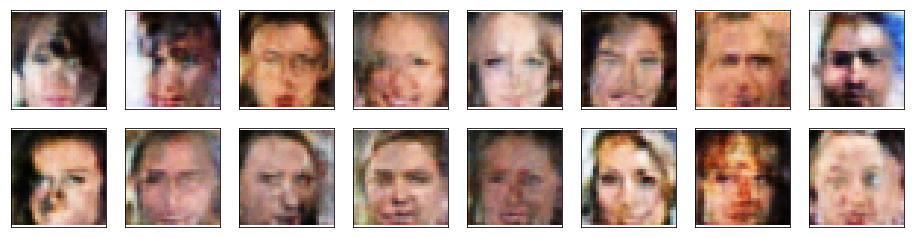

Epoch [    3/   20] | d_loss: 1.6370 | g_loss: 4.6337
Epoch [    3/   20] | d_loss: 0.9475 | g_loss: 2.6740
Epoch [    3/   20] | d_loss: 0.7050 | g_loss: 3.6989
Epoch [    3/   20] | d_loss: 0.5960 | g_loss: 2.5095
Epoch [    3/   20] | d_loss: 0.5692 | g_loss: 2.6064
Epoch [    3/   20] | d_loss: 0.4971 | g_loss: 3.5571
Epoch [    3/   20] | d_loss: 0.9099 | g_loss: 3.5485
Epoch [    3/   20] | d_loss: 1.3446 | g_loss: 4.9469
Epoch [    3/   20] | d_loss: 0.7898 | g_loss: 2.7347
Epoch [    3/   20] | d_loss: 2.1310 | g_loss: 0.8049
Epoch [    3/   20] | d_loss: 0.6395 | g_loss: 2.4163
Epoch [    3/   20] | d_loss: 0.8442 | g_loss: 1.4493
Epoch [    3/   20] | d_loss: 0.6913 | g_loss: 3.5802
Epoch [    3/   20] | d_loss: 1.4134 | g_loss: 5.5873
Epoch [    3/   20] | d_loss: 0.6767 | g_loss: 3.0049
Epoch [    3/   20] | d_loss: 1.0516 | g_loss: 2.6733
Epoch [    3/   20] | d_loss: 0.8494 | g_loss: 2.3959
Epoch [    3/   20] | d_loss: 0.9505 | g_loss: 1.6462
Epoch [    3/   20] | d_loss

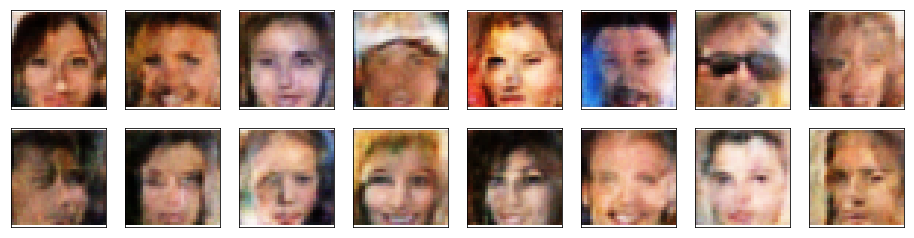

Epoch [    4/   20] | d_loss: 0.6640 | g_loss: 2.7282
Epoch [    4/   20] | d_loss: 0.7664 | g_loss: 2.3152
Epoch [    4/   20] | d_loss: 1.1427 | g_loss: 1.2723
Epoch [    4/   20] | d_loss: 0.5063 | g_loss: 2.8643
Epoch [    4/   20] | d_loss: 0.6401 | g_loss: 2.5651
Epoch [    4/   20] | d_loss: 0.9517 | g_loss: 2.7995
Epoch [    4/   20] | d_loss: 0.9070 | g_loss: 2.1197
Epoch [    4/   20] | d_loss: 1.1613 | g_loss: 1.4606
Epoch [    4/   20] | d_loss: 0.9707 | g_loss: 2.0069
Epoch [    4/   20] | d_loss: 0.2130 | g_loss: 4.9240
Epoch [    4/   20] | d_loss: 0.7409 | g_loss: 3.0181
Epoch [    4/   20] | d_loss: 0.9860 | g_loss: 3.9087
Epoch [    4/   20] | d_loss: 0.8302 | g_loss: 3.5757
Epoch [    4/   20] | d_loss: 1.4283 | g_loss: 4.1610
Epoch [    4/   20] | d_loss: 0.6581 | g_loss: 2.2671
Epoch [    4/   20] | d_loss: 0.6288 | g_loss: 4.0520
Epoch [    4/   20] | d_loss: 0.8516 | g_loss: 4.0877
Epoch [    4/   20] | d_loss: 1.1254 | g_loss: 2.6594
Epoch [    4/   20] | d_loss

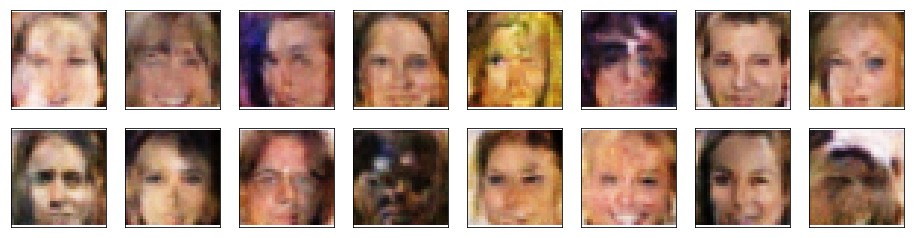

Epoch [    5/   20] | d_loss: 0.4456 | g_loss: 3.0142
Epoch [    5/   20] | d_loss: 0.3733 | g_loss: 3.1831
Epoch [    5/   20] | d_loss: 0.4582 | g_loss: 3.9187
Epoch [    5/   20] | d_loss: 0.9338 | g_loss: 4.2997
Epoch [    5/   20] | d_loss: 0.3178 | g_loss: 4.7378
Epoch [    5/   20] | d_loss: 0.4351 | g_loss: 3.3004
Epoch [    5/   20] | d_loss: 1.0240 | g_loss: 2.9690
Epoch [    5/   20] | d_loss: 0.8958 | g_loss: 1.5149
Epoch [    5/   20] | d_loss: 0.6201 | g_loss: 2.8364
Epoch [    5/   20] | d_loss: 1.4974 | g_loss: 2.3489
Epoch [    5/   20] | d_loss: 0.7199 | g_loss: 2.6131
Epoch [    5/   20] | d_loss: 0.6746 | g_loss: 2.2528
Epoch [    5/   20] | d_loss: 0.6268 | g_loss: 2.4740
Epoch [    5/   20] | d_loss: 0.4272 | g_loss: 4.2065
Epoch [    5/   20] | d_loss: 0.6972 | g_loss: 2.3663
Epoch [    5/   20] | d_loss: 0.9633 | g_loss: 4.1223
Epoch [    5/   20] | d_loss: 0.5023 | g_loss: 2.7679
Epoch [    5/   20] | d_loss: 0.3827 | g_loss: 3.8117
Epoch [    5/   20] | d_loss

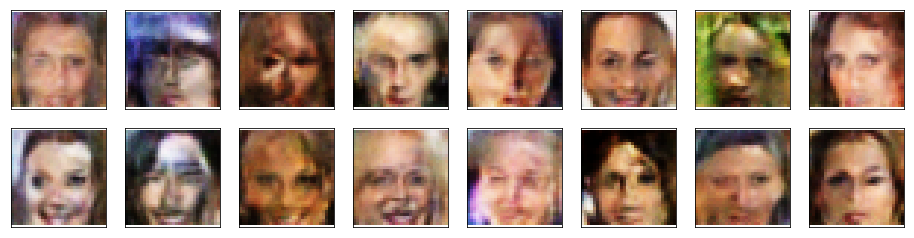

Epoch [    6/   20] | d_loss: 2.6822 | g_loss: 4.2841
Epoch [    6/   20] | d_loss: 0.8573 | g_loss: 2.9008
Epoch [    6/   20] | d_loss: 0.4443 | g_loss: 2.8140
Epoch [    6/   20] | d_loss: 0.7166 | g_loss: 2.8964
Epoch [    6/   20] | d_loss: 0.6691 | g_loss: 2.6028
Epoch [    6/   20] | d_loss: 0.6910 | g_loss: 2.8941
Epoch [    6/   20] | d_loss: 1.0389 | g_loss: 3.7556
Epoch [    6/   20] | d_loss: 0.5819 | g_loss: 2.6090
Epoch [    6/   20] | d_loss: 0.5153 | g_loss: 3.2141
Epoch [    6/   20] | d_loss: 1.0644 | g_loss: 2.6110
Epoch [    6/   20] | d_loss: 0.5329 | g_loss: 3.7314
Epoch [    6/   20] | d_loss: 0.8287 | g_loss: 2.6152
Epoch [    6/   20] | d_loss: 0.8451 | g_loss: 3.1847
Epoch [    6/   20] | d_loss: 0.5792 | g_loss: 2.3002
Epoch [    6/   20] | d_loss: 0.3355 | g_loss: 3.1371
Epoch [    6/   20] | d_loss: 0.5947 | g_loss: 2.6272
Epoch [    6/   20] | d_loss: 1.2526 | g_loss: 1.4368
Epoch [    6/   20] | d_loss: 1.0621 | g_loss: 2.9616
Epoch [    6/   20] | d_loss

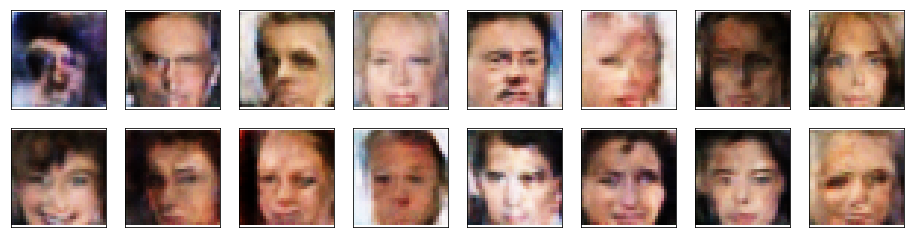

Epoch [    7/   20] | d_loss: 0.7952 | g_loss: 3.7773
Epoch [    7/   20] | d_loss: 0.3516 | g_loss: 2.7802
Epoch [    7/   20] | d_loss: 0.3180 | g_loss: 4.9587
Epoch [    7/   20] | d_loss: 0.7281 | g_loss: 4.8866
Epoch [    7/   20] | d_loss: 0.3001 | g_loss: 3.3194
Epoch [    7/   20] | d_loss: 0.2108 | g_loss: 3.6725
Epoch [    7/   20] | d_loss: 0.8689 | g_loss: 3.1315
Epoch [    7/   20] | d_loss: 1.0703 | g_loss: 4.3685
Epoch [    7/   20] | d_loss: 0.5621 | g_loss: 4.3734
Epoch [    7/   20] | d_loss: 0.4712 | g_loss: 2.6690
Epoch [    7/   20] | d_loss: 0.8488 | g_loss: 2.1238
Epoch [    7/   20] | d_loss: 0.3845 | g_loss: 2.7926
Epoch [    7/   20] | d_loss: 0.3191 | g_loss: 3.8951
Epoch [    7/   20] | d_loss: 0.8277 | g_loss: 5.2030
Epoch [    7/   20] | d_loss: 0.7130 | g_loss: 3.6715
Epoch [    7/   20] | d_loss: 0.9602 | g_loss: 1.8977
Epoch [    7/   20] | d_loss: 0.7449 | g_loss: 2.4969
Epoch [    7/   20] | d_loss: 0.4137 | g_loss: 3.5015
Epoch [    7/   20] | d_loss

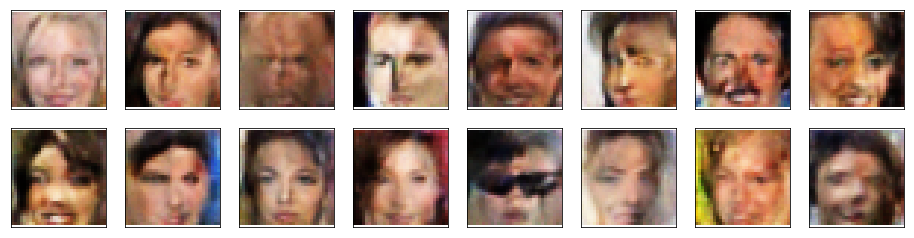

Epoch [    8/   20] | d_loss: 0.4863 | g_loss: 2.4884
Epoch [    8/   20] | d_loss: 2.7108 | g_loss: 3.0904
Epoch [    8/   20] | d_loss: 0.3385 | g_loss: 4.3510
Epoch [    8/   20] | d_loss: 0.7164 | g_loss: 4.5567
Epoch [    8/   20] | d_loss: 0.4104 | g_loss: 3.6055
Epoch [    8/   20] | d_loss: 0.6576 | g_loss: 3.7854
Epoch [    8/   20] | d_loss: 0.1455 | g_loss: 4.0657
Epoch [    8/   20] | d_loss: 0.5108 | g_loss: 3.2869
Epoch [    8/   20] | d_loss: 0.7602 | g_loss: 2.4755
Epoch [    8/   20] | d_loss: 0.3343 | g_loss: 2.5485
Epoch [    8/   20] | d_loss: 0.2965 | g_loss: 3.1171
Epoch [    8/   20] | d_loss: 0.7682 | g_loss: 5.4452
Epoch [    8/   20] | d_loss: 0.5891 | g_loss: 3.1665
Epoch [    8/   20] | d_loss: 1.0148 | g_loss: 2.8235
Epoch [    8/   20] | d_loss: 0.2390 | g_loss: 4.3907
Epoch [    8/   20] | d_loss: 0.5933 | g_loss: 3.9681
Epoch [    8/   20] | d_loss: 0.6918 | g_loss: 2.6842
Epoch [    8/   20] | d_loss: 0.7775 | g_loss: 3.0377
Epoch [    8/   20] | d_loss

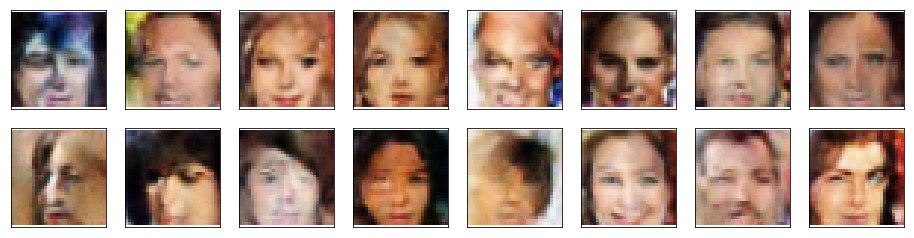

Epoch [    9/   20] | d_loss: 0.5077 | g_loss: 4.3538
Epoch [    9/   20] | d_loss: 1.1056 | g_loss: 1.0459
Epoch [    9/   20] | d_loss: 0.9746 | g_loss: 1.0090
Epoch [    9/   20] | d_loss: 0.2038 | g_loss: 4.3085
Epoch [    9/   20] | d_loss: 0.2860 | g_loss: 3.8783
Epoch [    9/   20] | d_loss: 1.0242 | g_loss: 1.3304
Epoch [    9/   20] | d_loss: 0.3188 | g_loss: 5.2930
Epoch [    9/   20] | d_loss: 0.7969 | g_loss: 2.1670
Epoch [    9/   20] | d_loss: 0.5664 | g_loss: 2.0645
Epoch [    9/   20] | d_loss: 0.4437 | g_loss: 2.9300
Epoch [    9/   20] | d_loss: 0.3860 | g_loss: 2.7531
Epoch [    9/   20] | d_loss: 0.2314 | g_loss: 3.7344
Epoch [    9/   20] | d_loss: 0.6997 | g_loss: 3.0840
Epoch [    9/   20] | d_loss: 0.6363 | g_loss: 3.6350
Epoch [    9/   20] | d_loss: 0.9458 | g_loss: 3.2377
Epoch [    9/   20] | d_loss: 0.3221 | g_loss: 3.6735
Epoch [    9/   20] | d_loss: 0.6317 | g_loss: 3.4339
Epoch [    9/   20] | d_loss: 0.5546 | g_loss: 3.2297
Epoch [    9/   20] | d_loss

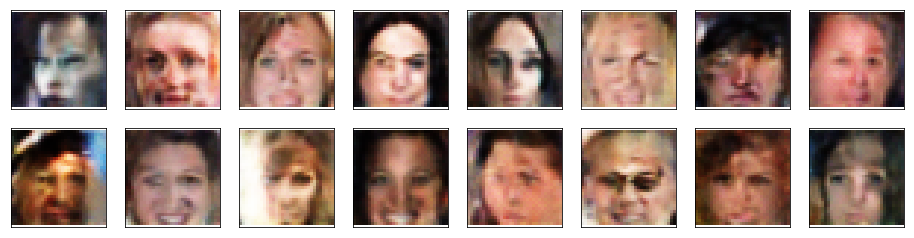

Epoch [   10/   20] | d_loss: 0.3989 | g_loss: 3.2525
Epoch [   10/   20] | d_loss: 0.3683 | g_loss: 3.4494
Epoch [   10/   20] | d_loss: 0.7363 | g_loss: 4.7400
Epoch [   10/   20] | d_loss: 0.4525 | g_loss: 2.8257
Epoch [   10/   20] | d_loss: 0.7163 | g_loss: 1.9868
Epoch [   10/   20] | d_loss: 0.9848 | g_loss: 5.8122
Epoch [   10/   20] | d_loss: 1.1127 | g_loss: 2.0617
Epoch [   10/   20] | d_loss: 0.8406 | g_loss: 3.4183
Epoch [   10/   20] | d_loss: 1.3593 | g_loss: 3.8451
Epoch [   10/   20] | d_loss: 0.6333 | g_loss: 2.2641
Epoch [   10/   20] | d_loss: 0.8585 | g_loss: 2.2290
Epoch [   10/   20] | d_loss: 0.8227 | g_loss: 3.0779
Epoch [   10/   20] | d_loss: 0.2894 | g_loss: 3.4903
Epoch [   10/   20] | d_loss: 0.8758 | g_loss: 2.4243
Epoch [   10/   20] | d_loss: 0.5659 | g_loss: 2.8167
Epoch [   10/   20] | d_loss: 0.1810 | g_loss: 4.0444
Epoch [   10/   20] | d_loss: 1.0752 | g_loss: 4.4050
Epoch [   10/   20] | d_loss: 0.4211 | g_loss: 4.6608
Epoch [   10/   20] | d_loss

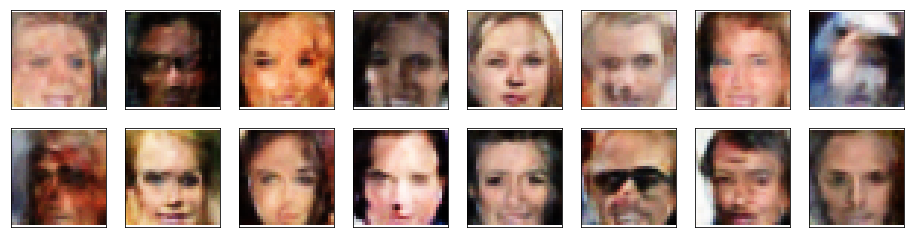

Epoch [   11/   20] | d_loss: 0.5464 | g_loss: 3.3508
Epoch [   11/   20] | d_loss: 0.3440 | g_loss: 3.4890
Epoch [   11/   20] | d_loss: 1.0376 | g_loss: 1.0650
Epoch [   11/   20] | d_loss: 0.5181 | g_loss: 4.0709
Epoch [   11/   20] | d_loss: 0.8600 | g_loss: 1.3427
Epoch [   11/   20] | d_loss: 0.6271 | g_loss: 2.0038
Epoch [   11/   20] | d_loss: 0.7917 | g_loss: 2.3829
Epoch [   11/   20] | d_loss: 0.6182 | g_loss: 2.9551
Epoch [   11/   20] | d_loss: 0.3572 | g_loss: 3.5092
Epoch [   11/   20] | d_loss: 0.3256 | g_loss: 3.3896
Epoch [   11/   20] | d_loss: 0.2379 | g_loss: 3.5973
Epoch [   11/   20] | d_loss: 0.2230 | g_loss: 5.0221
Epoch [   11/   20] | d_loss: 0.4926 | g_loss: 2.4932
Epoch [   11/   20] | d_loss: 0.9049 | g_loss: 1.3905
Epoch [   11/   20] | d_loss: 0.2321 | g_loss: 4.5458
Epoch [   11/   20] | d_loss: 0.6590 | g_loss: 3.5296
Epoch [   11/   20] | d_loss: 0.6132 | g_loss: 3.8771
Epoch [   11/   20] | d_loss: 0.2001 | g_loss: 3.9349
Epoch [   11/   20] | d_loss

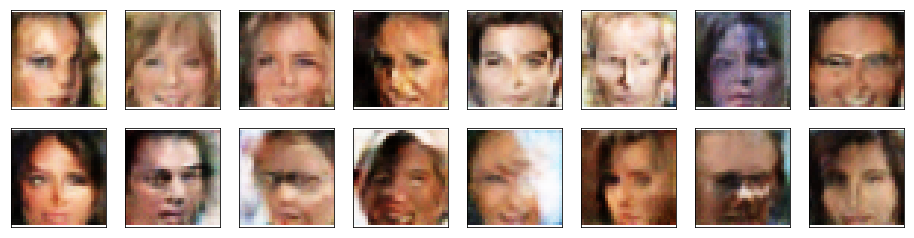

Epoch [   12/   20] | d_loss: 0.4501 | g_loss: 4.1824
Epoch [   12/   20] | d_loss: 0.4319 | g_loss: 2.6930
Epoch [   12/   20] | d_loss: 0.2141 | g_loss: 4.4923
Epoch [   12/   20] | d_loss: 0.1028 | g_loss: 5.0557
Epoch [   12/   20] | d_loss: 1.0804 | g_loss: 1.4368
Epoch [   12/   20] | d_loss: 1.4550 | g_loss: 1.2588
Epoch [   12/   20] | d_loss: 0.6006 | g_loss: 1.5015
Epoch [   12/   20] | d_loss: 0.0839 | g_loss: 4.6548
Epoch [   12/   20] | d_loss: 0.4883 | g_loss: 4.2140
Epoch [   12/   20] | d_loss: 0.2434 | g_loss: 4.4032
Epoch [   12/   20] | d_loss: 0.4590 | g_loss: 4.1551
Epoch [   12/   20] | d_loss: 0.4918 | g_loss: 2.4793
Epoch [   12/   20] | d_loss: 0.2834 | g_loss: 3.5682
Epoch [   12/   20] | d_loss: 0.5908 | g_loss: 3.4699
Epoch [   12/   20] | d_loss: 0.5723 | g_loss: 4.4504
Epoch [   12/   20] | d_loss: 0.1763 | g_loss: 3.8383
Epoch [   12/   20] | d_loss: 0.6172 | g_loss: 3.4178
Epoch [   12/   20] | d_loss: 0.1964 | g_loss: 4.9960
Epoch [   12/   20] | d_loss

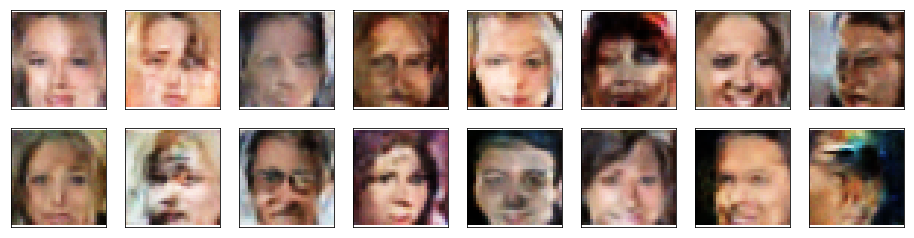

Epoch [   13/   20] | d_loss: 0.1739 | g_loss: 4.6229
Epoch [   13/   20] | d_loss: 0.2126 | g_loss: 3.7803
Epoch [   13/   20] | d_loss: 0.5825 | g_loss: 3.7236
Epoch [   13/   20] | d_loss: 0.7806 | g_loss: 2.0252
Epoch [   13/   20] | d_loss: 0.1349 | g_loss: 5.3879
Epoch [   13/   20] | d_loss: 0.5016 | g_loss: 2.6982
Epoch [   13/   20] | d_loss: 0.6218 | g_loss: 2.8347
Epoch [   13/   20] | d_loss: 0.6698 | g_loss: 3.6394
Epoch [   13/   20] | d_loss: 0.7148 | g_loss: 2.7554
Epoch [   13/   20] | d_loss: 0.3070 | g_loss: 2.8054
Epoch [   13/   20] | d_loss: 0.3773 | g_loss: 3.6416
Epoch [   13/   20] | d_loss: 0.9543 | g_loss: 2.1945
Epoch [   13/   20] | d_loss: 0.7267 | g_loss: 3.0302
Epoch [   13/   20] | d_loss: 1.1410 | g_loss: 4.0373
Epoch [   13/   20] | d_loss: 0.1448 | g_loss: 4.1463
Epoch [   13/   20] | d_loss: 0.7740 | g_loss: 2.5993
Epoch [   13/   20] | d_loss: 0.5408 | g_loss: 4.0875
Epoch [   13/   20] | d_loss: 0.1067 | g_loss: 4.2990
Epoch [   13/   20] | d_loss

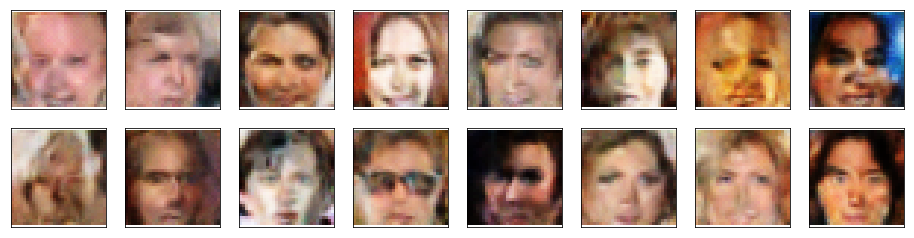

Epoch [   14/   20] | d_loss: 0.3795 | g_loss: 4.9734
Epoch [   14/   20] | d_loss: 1.6524 | g_loss: 5.6190
Epoch [   14/   20] | d_loss: 0.4372 | g_loss: 4.5881
Epoch [   14/   20] | d_loss: 0.4690 | g_loss: 3.6506
Epoch [   14/   20] | d_loss: 0.6844 | g_loss: 4.2979
Epoch [   14/   20] | d_loss: 0.2001 | g_loss: 3.8961
Epoch [   14/   20] | d_loss: 0.9133 | g_loss: 4.0933
Epoch [   14/   20] | d_loss: 0.4485 | g_loss: 3.1207
Epoch [   14/   20] | d_loss: 0.4695 | g_loss: 2.8004
Epoch [   14/   20] | d_loss: 0.0574 | g_loss: 6.8521
Epoch [   14/   20] | d_loss: 0.4941 | g_loss: 4.7335
Epoch [   14/   20] | d_loss: 0.9194 | g_loss: 1.6980
Epoch [   14/   20] | d_loss: 0.4865 | g_loss: 2.7475
Epoch [   14/   20] | d_loss: 0.4533 | g_loss: 3.1885
Epoch [   14/   20] | d_loss: 0.0883 | g_loss: 5.4426
Epoch [   14/   20] | d_loss: 0.7283 | g_loss: 3.1922
Epoch [   14/   20] | d_loss: 0.3962 | g_loss: 4.6743
Epoch [   14/   20] | d_loss: 0.4263 | g_loss: 3.9869
Epoch [   14/   20] | d_loss

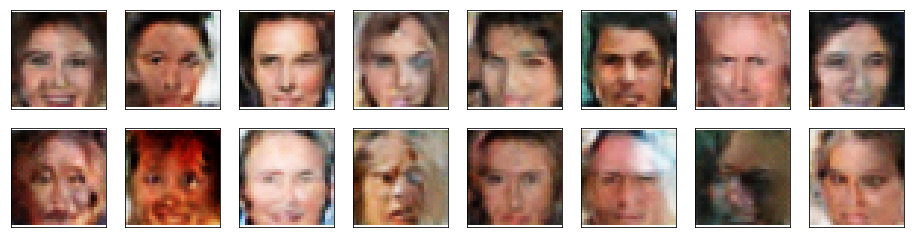

Epoch [   15/   20] | d_loss: 0.5728 | g_loss: 1.7771
Epoch [   15/   20] | d_loss: 1.4867 | g_loss: 5.7378
Epoch [   15/   20] | d_loss: 0.6301 | g_loss: 3.3157
Epoch [   15/   20] | d_loss: 0.5423 | g_loss: 6.1558
Epoch [   15/   20] | d_loss: 0.3451 | g_loss: 4.1216
Epoch [   15/   20] | d_loss: 0.6849 | g_loss: 5.0092
Epoch [   15/   20] | d_loss: 0.4776 | g_loss: 3.2915
Epoch [   15/   20] | d_loss: 0.1845 | g_loss: 4.2211
Epoch [   15/   20] | d_loss: 0.4222 | g_loss: 4.4142
Epoch [   15/   20] | d_loss: 1.2015 | g_loss: 1.0149
Epoch [   15/   20] | d_loss: 0.4193 | g_loss: 3.9192
Epoch [   15/   20] | d_loss: 1.8084 | g_loss: 0.4824
Epoch [   15/   20] | d_loss: 0.5025 | g_loss: 3.4008
Epoch [   15/   20] | d_loss: 0.6965 | g_loss: 3.8939
Epoch [   15/   20] | d_loss: 0.5400 | g_loss: 3.3108
Epoch [   15/   20] | d_loss: 0.3991 | g_loss: 4.6852


KeyboardInterrupt: 

In [20]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.3799 | g_loss: 1.5631
Epoch [    1/   20] | d_loss: 0.8676 | g_loss: 2.9476
Epoch [    1/   20] | d_loss: 1.0745 | g_loss: 0.9547
Epoch [    1/   20] | d_loss: 1.0859 | g_loss: 1.1885
Epoch [    1/   20] | d_loss: 1.2674 | g_loss: 1.2497
Epoch [    1/   20] | d_loss: 1.1944 | g_loss: 1.1768
Epoch [    1/   20] | d_loss: 1.1177 | g_loss: 2.2028
Epoch [    1/   20] | d_loss: 0.9102 | g_loss: 1.8250
Epoch [    1/   20] | d_loss: 1.2201 | g_loss: 1.8779
Epoch [    1/   20] | d_loss: 1.0421 | g_loss: 1.4254
Epoch [    1/   20] | d_loss: 1.4666 | g_loss: 0.8010
Epoch [    1/   20] | d_loss: 1.1071 | g_loss: 1.9676
Epoch [    1/   20] | d_loss: 0.9872 | g_loss: 1.7684
Epoch [    1/   20] | d_loss: 1.1357 | g_loss: 2.9819
Epoch [    1/   20] | d_loss: 0.9678 | g_loss: 2.2606
Epoch [    1/   20] | d_loss: 0.9200 | g_loss: 1.6362
Epoch [    1/   20] | d_loss: 0.7327 | g_loss: 2.4776
Epoch [    1/   20] | d_loss: 0.7342 | g_loss: 2.3974
Epoch [    1/   20] | d_loss

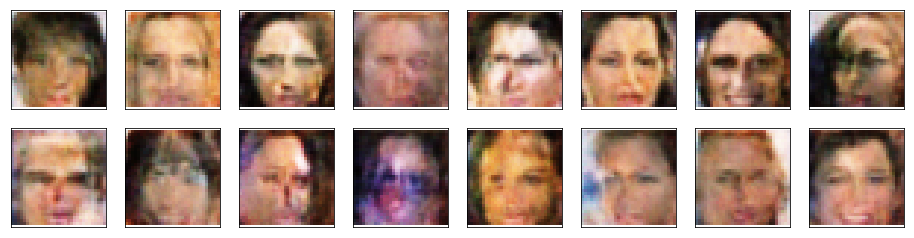

Epoch [    2/   20] | d_loss: 1.3184 | g_loss: 1.2233
Epoch [    2/   20] | d_loss: 1.3491 | g_loss: 2.5516
Epoch [    2/   20] | d_loss: 1.0646 | g_loss: 1.4152
Epoch [    2/   20] | d_loss: 1.1613 | g_loss: 1.0112
Epoch [    2/   20] | d_loss: 0.9985 | g_loss: 1.9289
Epoch [    2/   20] | d_loss: 0.9697 | g_loss: 1.9295
Epoch [    2/   20] | d_loss: 1.0552 | g_loss: 3.3149
Epoch [    2/   20] | d_loss: 0.4921 | g_loss: 2.8587
Epoch [    2/   20] | d_loss: 0.6759 | g_loss: 2.0151
Epoch [    2/   20] | d_loss: 0.8259 | g_loss: 2.1547
Epoch [    2/   20] | d_loss: 1.1426 | g_loss: 1.3561
Epoch [    2/   20] | d_loss: 0.9122 | g_loss: 3.1885
Epoch [    2/   20] | d_loss: 0.8842 | g_loss: 2.0495
Epoch [    2/   20] | d_loss: 0.6158 | g_loss: 2.4468
Epoch [    2/   20] | d_loss: 0.7060 | g_loss: 2.6354
Epoch [    2/   20] | d_loss: 0.5463 | g_loss: 2.5565
Epoch [    2/   20] | d_loss: 0.9594 | g_loss: 1.9092
Epoch [    2/   20] | d_loss: 1.0248 | g_loss: 2.0105
Epoch [    2/   20] | d_loss

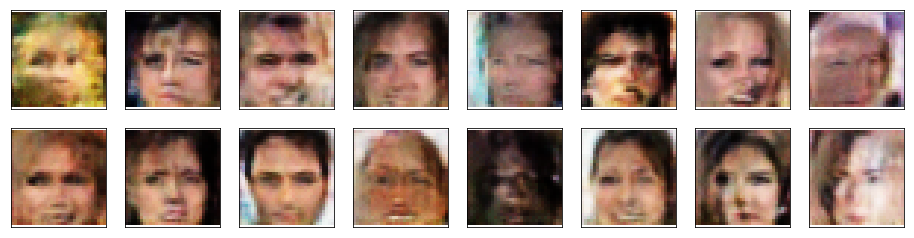

Epoch [    3/   20] | d_loss: 0.7383 | g_loss: 2.5373
Epoch [    3/   20] | d_loss: 0.6947 | g_loss: 3.3188
Epoch [    3/   20] | d_loss: 0.9848 | g_loss: 1.7385
Epoch [    3/   20] | d_loss: 0.5039 | g_loss: 3.2807
Epoch [    3/   20] | d_loss: 1.0702 | g_loss: 1.6623
Epoch [    3/   20] | d_loss: 0.6788 | g_loss: 1.9844
Epoch [    3/   20] | d_loss: 0.7267 | g_loss: 2.7083
Epoch [    3/   20] | d_loss: 0.7708 | g_loss: 2.1933
Epoch [    3/   20] | d_loss: 1.0122 | g_loss: 2.9395
Epoch [    3/   20] | d_loss: 0.7907 | g_loss: 3.6759
Epoch [    3/   20] | d_loss: 0.7255 | g_loss: 1.6076
Epoch [    3/   20] | d_loss: 0.6302 | g_loss: 2.9744
Epoch [    3/   20] | d_loss: 0.6774 | g_loss: 2.8278
Epoch [    3/   20] | d_loss: 1.2038 | g_loss: 1.7538
Epoch [    3/   20] | d_loss: 0.3831 | g_loss: 3.7385
Epoch [    3/   20] | d_loss: 1.0019 | g_loss: 1.9402
Epoch [    3/   20] | d_loss: 0.7686 | g_loss: 3.0322
Epoch [    3/   20] | d_loss: 0.9808 | g_loss: 2.2088
Epoch [    3/   20] | d_loss

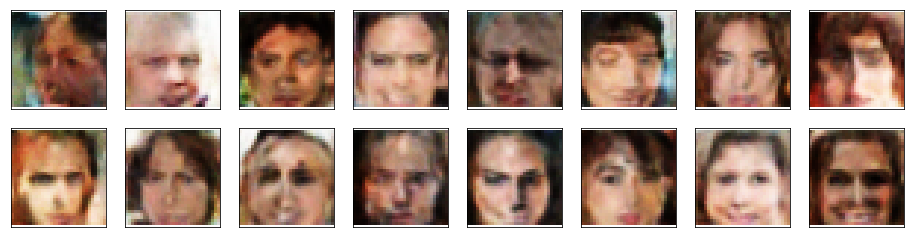

Epoch [    4/   20] | d_loss: 0.5864 | g_loss: 2.8866
Epoch [    4/   20] | d_loss: 1.3573 | g_loss: 2.3582
Epoch [    4/   20] | d_loss: 0.8441 | g_loss: 2.6609
Epoch [    4/   20] | d_loss: 1.3989 | g_loss: 1.2971
Epoch [    4/   20] | d_loss: 0.6920 | g_loss: 2.9535
Epoch [    4/   20] | d_loss: 0.9216 | g_loss: 2.3181
Epoch [    4/   20] | d_loss: 0.7565 | g_loss: 2.9831
Epoch [    4/   20] | d_loss: 0.8119 | g_loss: 2.3777
Epoch [    4/   20] | d_loss: 1.2901 | g_loss: 1.5772
Epoch [    4/   20] | d_loss: 1.7028 | g_loss: 1.2521
Epoch [    4/   20] | d_loss: 0.5817 | g_loss: 2.4470
Epoch [    4/   20] | d_loss: 0.6913 | g_loss: 2.4812
Epoch [    4/   20] | d_loss: 0.7104 | g_loss: 3.0104
Epoch [    4/   20] | d_loss: 0.6410 | g_loss: 2.2198
Epoch [    4/   20] | d_loss: 0.8107 | g_loss: 3.7260
Epoch [    4/   20] | d_loss: 0.7295 | g_loss: 2.8033
Epoch [    4/   20] | d_loss: 0.4855 | g_loss: 3.0971
Epoch [    4/   20] | d_loss: 0.6594 | g_loss: 2.4098
Epoch [    4/   20] | d_loss

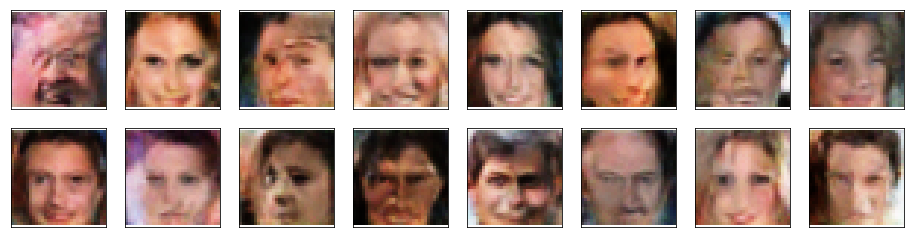

Epoch [    5/   20] | d_loss: 1.2927 | g_loss: 1.4465
Epoch [    5/   20] | d_loss: 0.6915 | g_loss: 3.9997
Epoch [    5/   20] | d_loss: 1.0265 | g_loss: 2.3760
Epoch [    5/   20] | d_loss: 1.7016 | g_loss: 0.7340
Epoch [    5/   20] | d_loss: 0.5178 | g_loss: 1.9821
Epoch [    5/   20] | d_loss: 0.4503 | g_loss: 2.9066
Epoch [    5/   20] | d_loss: 1.0565 | g_loss: 1.3537
Epoch [    5/   20] | d_loss: 0.8920 | g_loss: 2.4638
Epoch [    5/   20] | d_loss: 1.0903 | g_loss: 1.4406
Epoch [    5/   20] | d_loss: 0.5248 | g_loss: 2.4653
Epoch [    5/   20] | d_loss: 0.8987 | g_loss: 1.9173
Epoch [    5/   20] | d_loss: 0.9266 | g_loss: 1.0753
Epoch [    5/   20] | d_loss: 0.4523 | g_loss: 2.7196
Epoch [    5/   20] | d_loss: 0.3270 | g_loss: 3.1320
Epoch [    5/   20] | d_loss: 1.1639 | g_loss: 1.3689
Epoch [    5/   20] | d_loss: 0.5278 | g_loss: 2.8467
Epoch [    5/   20] | d_loss: 0.9238 | g_loss: 2.2971
Epoch [    5/   20] | d_loss: 1.1939 | g_loss: 1.3604
Epoch [    5/   20] | d_loss

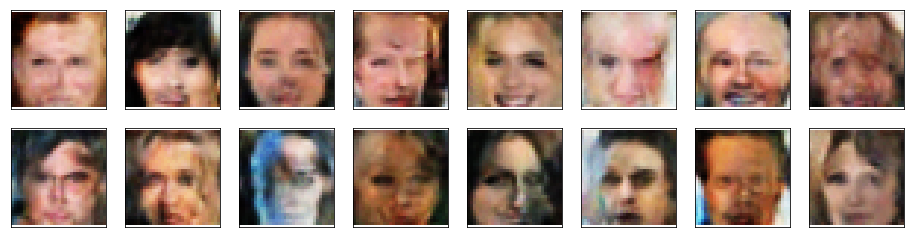

Epoch [    6/   20] | d_loss: 1.1724 | g_loss: 2.7392
Epoch [    6/   20] | d_loss: 0.4635 | g_loss: 3.1464
Epoch [    6/   20] | d_loss: 0.8721 | g_loss: 3.3493
Epoch [    6/   20] | d_loss: 0.8887 | g_loss: 1.9597
Epoch [    6/   20] | d_loss: 0.4623 | g_loss: 3.4178
Epoch [    6/   20] | d_loss: 0.6725 | g_loss: 2.4238
Epoch [    6/   20] | d_loss: 1.0275 | g_loss: 2.4721
Epoch [    6/   20] | d_loss: 0.5325 | g_loss: 2.5071
Epoch [    6/   20] | d_loss: 0.5661 | g_loss: 2.5841
Epoch [    6/   20] | d_loss: 0.8225 | g_loss: 2.5055
Epoch [    6/   20] | d_loss: 0.7798 | g_loss: 2.0014
Epoch [    6/   20] | d_loss: 0.9747 | g_loss: 2.6328
Epoch [    6/   20] | d_loss: 0.3688 | g_loss: 3.4856
Epoch [    6/   20] | d_loss: 0.8640 | g_loss: 1.8573
Epoch [    6/   20] | d_loss: 0.4489 | g_loss: 3.6697
Epoch [    6/   20] | d_loss: 0.7260 | g_loss: 2.8005
Epoch [    6/   20] | d_loss: 0.4391 | g_loss: 2.8126
Epoch [    6/   20] | d_loss: 1.1378 | g_loss: 0.9602
Epoch [    6/   20] | d_loss

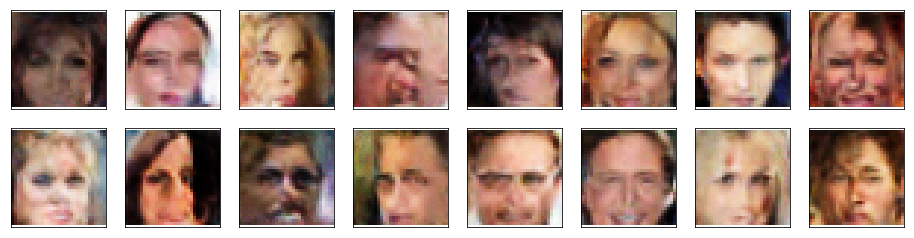

Epoch [    7/   20] | d_loss: 0.7493 | g_loss: 2.3861
Epoch [    7/   20] | d_loss: 1.8283 | g_loss: 1.5481
Epoch [    7/   20] | d_loss: 0.9804 | g_loss: 2.7712
Epoch [    7/   20] | d_loss: 0.6811 | g_loss: 2.5201
Epoch [    7/   20] | d_loss: 0.3984 | g_loss: 3.3048
Epoch [    7/   20] | d_loss: 0.8782 | g_loss: 1.7823
Epoch [    7/   20] | d_loss: 0.2979 | g_loss: 3.3792
Epoch [    7/   20] | d_loss: 0.5307 | g_loss: 3.1387
Epoch [    7/   20] | d_loss: 0.3832 | g_loss: 3.5191
Epoch [    7/   20] | d_loss: 0.7143 | g_loss: 2.3234
Epoch [    7/   20] | d_loss: 1.3383 | g_loss: 0.9380
Epoch [    7/   20] | d_loss: 0.4931 | g_loss: 3.2360
Epoch [    7/   20] | d_loss: 0.7514 | g_loss: 2.3992
Epoch [    7/   20] | d_loss: 0.7634 | g_loss: 2.3464
Epoch [    7/   20] | d_loss: 0.5872 | g_loss: 3.1745
Epoch [    7/   20] | d_loss: 0.3538 | g_loss: 3.2453
Epoch [    7/   20] | d_loss: 0.7802 | g_loss: 1.6298
Epoch [    7/   20] | d_loss: 2.4579 | g_loss: 0.7855
Epoch [    7/   20] | d_loss

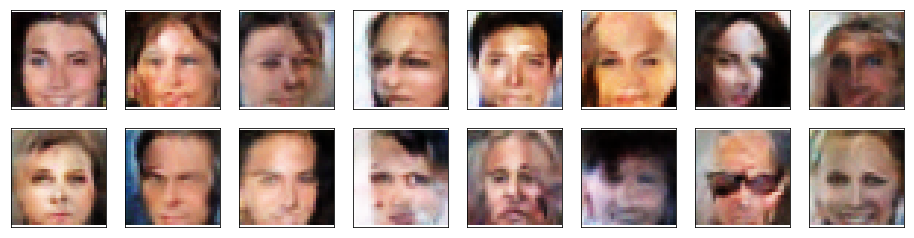

Epoch [    8/   20] | d_loss: 1.0462 | g_loss: 1.4678
Epoch [    8/   20] | d_loss: 0.8816 | g_loss: 1.6565
Epoch [    8/   20] | d_loss: 0.6485 | g_loss: 3.6398
Epoch [    8/   20] | d_loss: 1.1700 | g_loss: 3.0527
Epoch [    8/   20] | d_loss: 0.9446 | g_loss: 3.5300
Epoch [    8/   20] | d_loss: 0.4760 | g_loss: 2.8202
Epoch [    8/   20] | d_loss: 0.7655 | g_loss: 2.6738
Epoch [    8/   20] | d_loss: 0.4221 | g_loss: 2.9927
Epoch [    8/   20] | d_loss: 0.1517 | g_loss: 3.7987
Epoch [    8/   20] | d_loss: 1.1319 | g_loss: 1.2901
Epoch [    8/   20] | d_loss: 1.5810 | g_loss: 0.9800
Epoch [    8/   20] | d_loss: 0.2119 | g_loss: 3.2483
Epoch [    8/   20] | d_loss: 1.0804 | g_loss: 2.7117
Epoch [    8/   20] | d_loss: 0.5469 | g_loss: 3.0344
Epoch [    8/   20] | d_loss: 0.8475 | g_loss: 2.8840
Epoch [    8/   20] | d_loss: 0.4013 | g_loss: 2.5881
Epoch [    8/   20] | d_loss: 0.2149 | g_loss: 3.9222
Epoch [    8/   20] | d_loss: 0.3864 | g_loss: 3.8882
Epoch [    8/   20] | d_loss

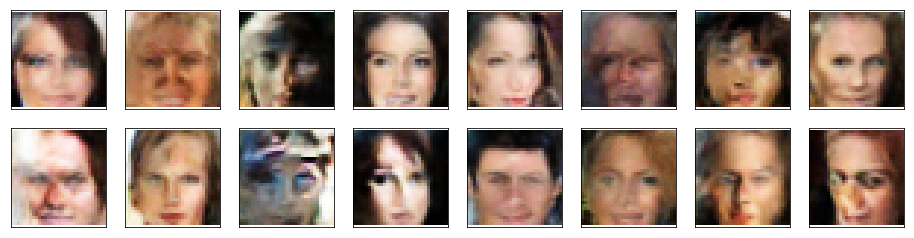

Epoch [    9/   20] | d_loss: 0.6790 | g_loss: 3.7427
Epoch [    9/   20] | d_loss: 0.3377 | g_loss: 3.4521
Epoch [    9/   20] | d_loss: 0.5274 | g_loss: 2.5743
Epoch [    9/   20] | d_loss: 0.3647 | g_loss: 2.8633
Epoch [    9/   20] | d_loss: 0.1487 | g_loss: 3.1708
Epoch [    9/   20] | d_loss: 0.9808 | g_loss: 2.0037
Epoch [    9/   20] | d_loss: 0.2378 | g_loss: 4.3636
Epoch [    9/   20] | d_loss: 0.5704 | g_loss: 2.9154
Epoch [    9/   20] | d_loss: 0.7808 | g_loss: 2.7167
Epoch [    9/   20] | d_loss: 0.5306 | g_loss: 2.9120
Epoch [    9/   20] | d_loss: 0.6215 | g_loss: 3.3901
Epoch [    9/   20] | d_loss: 1.5165 | g_loss: 2.0663
Epoch [    9/   20] | d_loss: 0.4433 | g_loss: 2.7643
Epoch [    9/   20] | d_loss: 0.5757 | g_loss: 3.2030
Epoch [    9/   20] | d_loss: 0.4022 | g_loss: 2.7478
Epoch [    9/   20] | d_loss: 0.4507 | g_loss: 3.3048
Epoch [    9/   20] | d_loss: 1.0150 | g_loss: 1.4892
Epoch [    9/   20] | d_loss: 0.3558 | g_loss: 2.7438
Epoch [    9/   20] | d_loss

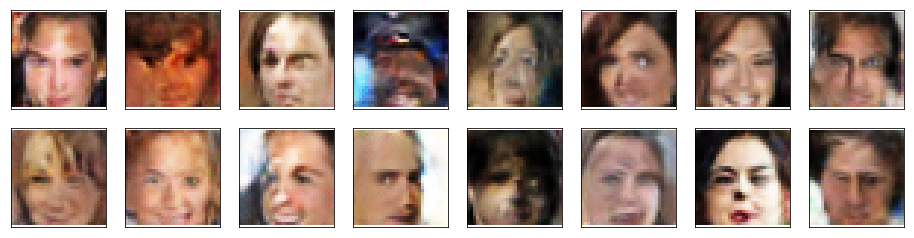

Epoch [   10/   20] | d_loss: 0.5080 | g_loss: 3.0504
Epoch [   10/   20] | d_loss: 0.1353 | g_loss: 4.8253
Epoch [   10/   20] | d_loss: 0.3014 | g_loss: 3.3486
Epoch [   10/   20] | d_loss: 1.1823 | g_loss: 1.9584
Epoch [   10/   20] | d_loss: 0.3823 | g_loss: 3.3164
Epoch [   10/   20] | d_loss: 0.1962 | g_loss: 3.6521
Epoch [   10/   20] | d_loss: 1.1372 | g_loss: 1.4026
Epoch [   10/   20] | d_loss: 0.8565 | g_loss: 2.2758
Epoch [   10/   20] | d_loss: 0.1610 | g_loss: 3.4978
Epoch [   10/   20] | d_loss: 0.8180 | g_loss: 1.9704
Epoch [   10/   20] | d_loss: 0.0654 | g_loss: 4.5251
Epoch [   10/   20] | d_loss: 0.8613 | g_loss: 3.1864
Epoch [   10/   20] | d_loss: 1.3361 | g_loss: 1.1818
Epoch [   10/   20] | d_loss: 0.2184 | g_loss: 3.4786
Epoch [   10/   20] | d_loss: 0.2536 | g_loss: 4.1655
Epoch [   10/   20] | d_loss: 0.9276 | g_loss: 2.5873
Epoch [   10/   20] | d_loss: 0.1705 | g_loss: 3.9725
Epoch [   10/   20] | d_loss: 0.1399 | g_loss: 3.7654
Epoch [   10/   20] | d_loss

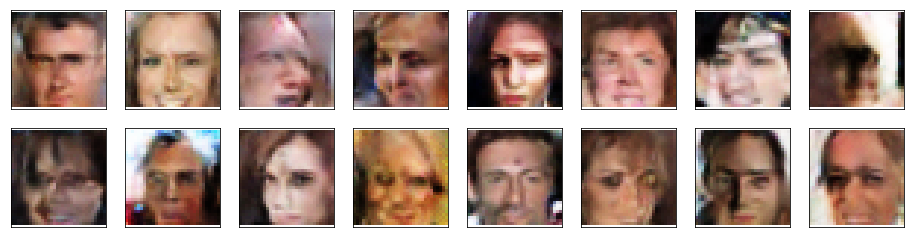

Epoch [   11/   20] | d_loss: 0.1668 | g_loss: 4.8467
Epoch [   11/   20] | d_loss: 0.1838 | g_loss: 3.4719
Epoch [   11/   20] | d_loss: 0.5139 | g_loss: 2.7956
Epoch [   11/   20] | d_loss: 1.1097 | g_loss: 3.7696
Epoch [   11/   20] | d_loss: 0.2471 | g_loss: 3.6652
Epoch [   11/   20] | d_loss: 0.4503 | g_loss: 2.8632
Epoch [   11/   20] | d_loss: 0.5702 | g_loss: 2.7260
Epoch [   11/   20] | d_loss: 0.2711 | g_loss: 3.7637
Epoch [   11/   20] | d_loss: 0.9188 | g_loss: 4.3548
Epoch [   11/   20] | d_loss: 0.8709 | g_loss: 2.2911
Epoch [   11/   20] | d_loss: 1.5509 | g_loss: 1.7987
Epoch [   11/   20] | d_loss: 0.2312 | g_loss: 2.9383
Epoch [   11/   20] | d_loss: 0.5863 | g_loss: 2.7399
Epoch [   11/   20] | d_loss: 0.8230 | g_loss: 3.1520
Epoch [   11/   20] | d_loss: 1.0849 | g_loss: 3.1212
Epoch [   11/   20] | d_loss: 0.8431 | g_loss: 1.9711
Epoch [   11/   20] | d_loss: 0.4180 | g_loss: 2.6849
Epoch [   11/   20] | d_loss: 3.2363 | g_loss: 0.7842
Epoch [   11/   20] | d_loss

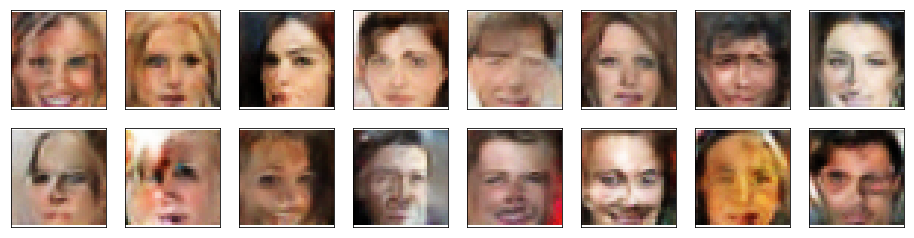

Epoch [   12/   20] | d_loss: 0.2714 | g_loss: 3.9139
Epoch [   12/   20] | d_loss: 0.1402 | g_loss: 3.1620
Epoch [   12/   20] | d_loss: 0.4709 | g_loss: 3.3230
Epoch [   12/   20] | d_loss: 0.1848 | g_loss: 4.3165
Epoch [   12/   20] | d_loss: 0.5745 | g_loss: 3.0343
Epoch [   12/   20] | d_loss: 0.4678 | g_loss: 2.6807
Epoch [   12/   20] | d_loss: 0.1809 | g_loss: 4.2940
Epoch [   12/   20] | d_loss: 0.5110 | g_loss: 2.8729
Epoch [   12/   20] | d_loss: 0.3640 | g_loss: 2.2255
Epoch [   12/   20] | d_loss: 0.2754 | g_loss: 4.8349
Epoch [   12/   20] | d_loss: 0.4739 | g_loss: 4.4394
Epoch [   12/   20] | d_loss: 0.5666 | g_loss: 2.4972
Epoch [   12/   20] | d_loss: 0.2574 | g_loss: 2.8488
Epoch [   12/   20] | d_loss: 0.4096 | g_loss: 3.1675
Epoch [   12/   20] | d_loss: 0.1964 | g_loss: 4.0390
Epoch [   12/   20] | d_loss: 2.0445 | g_loss: 3.0062
Epoch [   12/   20] | d_loss: 0.4851 | g_loss: 2.3585
Epoch [   12/   20] | d_loss: 0.9815 | g_loss: 4.4098
Epoch [   12/   20] | d_loss

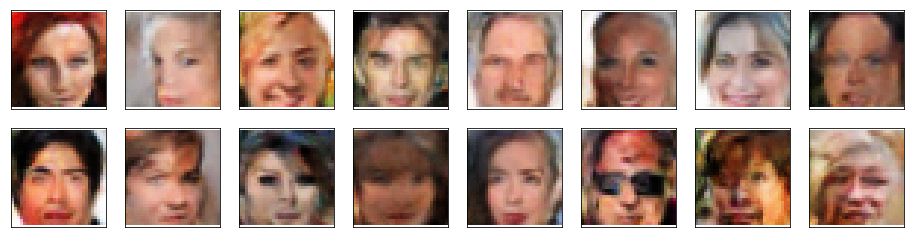

Epoch [   13/   20] | d_loss: 0.2123 | g_loss: 3.5695
Epoch [   13/   20] | d_loss: 0.9650 | g_loss: 1.3787
Epoch [   13/   20] | d_loss: 0.4324 | g_loss: 2.3335
Epoch [   13/   20] | d_loss: 0.2173 | g_loss: 3.2775
Epoch [   13/   20] | d_loss: 1.1504 | g_loss: 3.3628
Epoch [   13/   20] | d_loss: 0.3789 | g_loss: 2.3323
Epoch [   13/   20] | d_loss: 0.1290 | g_loss: 4.6031
Epoch [   13/   20] | d_loss: 0.2007 | g_loss: 3.3526
Epoch [   13/   20] | d_loss: 0.1307 | g_loss: 4.5092
Epoch [   13/   20] | d_loss: 0.2898 | g_loss: 2.8352
Epoch [   13/   20] | d_loss: 0.9462 | g_loss: 4.0533
Epoch [   13/   20] | d_loss: 0.2618 | g_loss: 3.8241
Epoch [   13/   20] | d_loss: 0.5643 | g_loss: 2.4587
Epoch [   13/   20] | d_loss: 0.5156 | g_loss: 3.8683
Epoch [   13/   20] | d_loss: 0.3122 | g_loss: 3.1640
Epoch [   13/   20] | d_loss: 0.5648 | g_loss: 5.1967
Epoch [   13/   20] | d_loss: 1.0010 | g_loss: 4.3402
Epoch [   13/   20] | d_loss: 1.4965 | g_loss: 0.7997
Epoch [   13/   20] | d_loss

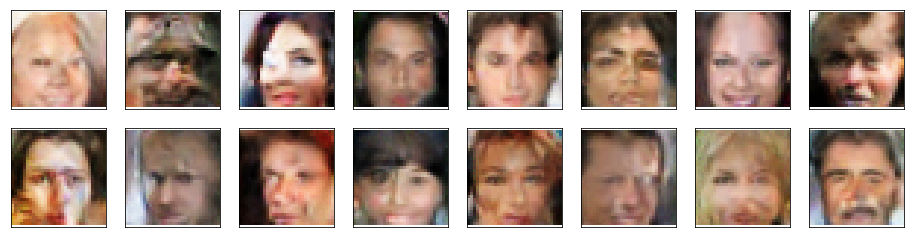

Epoch [   14/   20] | d_loss: 0.5272 | g_loss: 2.3749
Epoch [   14/   20] | d_loss: 0.1324 | g_loss: 4.2002
Epoch [   14/   20] | d_loss: 0.2271 | g_loss: 4.0440
Epoch [   14/   20] | d_loss: 0.6490 | g_loss: 4.4908
Epoch [   14/   20] | d_loss: 0.4113 | g_loss: 2.5823
Epoch [   14/   20] | d_loss: 0.5939 | g_loss: 3.9588
Epoch [   14/   20] | d_loss: 0.9869 | g_loss: 5.0969
Epoch [   14/   20] | d_loss: 0.0934 | g_loss: 4.8317
Epoch [   14/   20] | d_loss: 0.0293 | g_loss: 5.7903
Epoch [   14/   20] | d_loss: 0.0892 | g_loss: 3.6641
Epoch [   14/   20] | d_loss: 0.6607 | g_loss: 2.4784
Epoch [   14/   20] | d_loss: 0.4764 | g_loss: 3.6239
Epoch [   14/   20] | d_loss: 0.5073 | g_loss: 5.0476
Epoch [   14/   20] | d_loss: 0.1084 | g_loss: 3.8762
Epoch [   14/   20] | d_loss: 0.0709 | g_loss: 4.8574
Epoch [   14/   20] | d_loss: 0.3176 | g_loss: 3.2343
Epoch [   14/   20] | d_loss: 0.0689 | g_loss: 4.7637
Epoch [   14/   20] | d_loss: 0.1702 | g_loss: 4.0804
Epoch [   14/   20] | d_loss

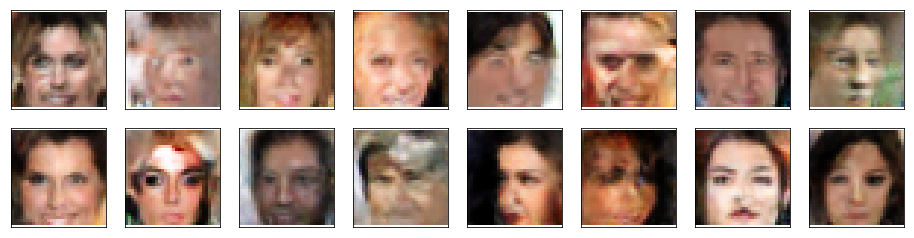

Epoch [   15/   20] | d_loss: 0.5869 | g_loss: 5.5706
Epoch [   15/   20] | d_loss: 0.0264 | g_loss: 5.3766
Epoch [   15/   20] | d_loss: 0.1304 | g_loss: 3.5316
Epoch [   15/   20] | d_loss: 0.6202 | g_loss: 1.7853


In [ ]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

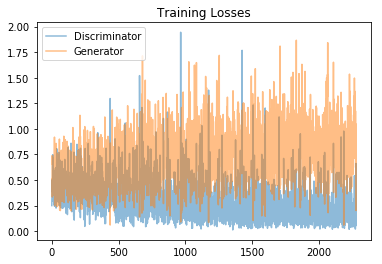

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

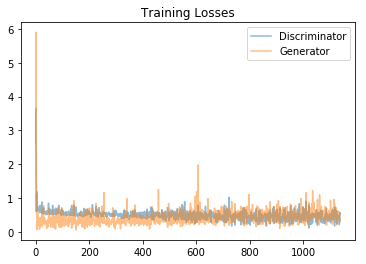

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [3]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [4]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

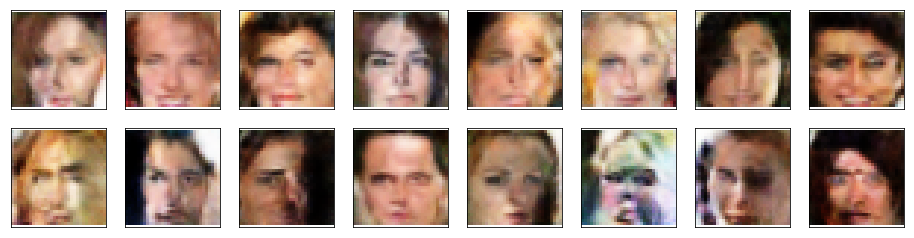

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:**
* The dataset is biased, so many artificial human faces are white celebrities' faces.
* The more complex the generator model is, the better performance the generator will have (The generated human faces are more likely to capture the features of human faces.) And at first, during the training process, the loss of the discrimator will gradually decrease to 0.3 while that of the generator will increase to 4-5. When I add dropout layers, their loss will be stable so the generator can actually learn.
* I tried different learning rates and finally finds that the 0.0001 is too slow while the 0.0005 is too fast, the 0.0002 is the appropriate value. For the number of epochs, the 20 is always a good choice.
* The result shows that the model is still not good because they are just like human faces but also have some flaws. The model can be improved by increasing number of epochs or establishing more complicated models.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.